# ATMS 523 Final Exam

## Instructions
A client asks you to develop a frost risk model for their strawberry farm in Plant City, Florida.  As a first step in that process, you would like to understand the occurrence of these events by month and some information about the atmospheric conditions that generate frost in the location based on climatological records.  You remember that your ATMS 523 professor back in graduate school taught you some tricks that might be able to help. Using the code provided from Module 3, load in the GHCN-D daily temperature records from Plant City (Station USC00087205).

1) Strawberries are planted around October 1 and ready for harvest by the end of January. What is the mean risk of frost and freeze, defined as the mean number of days per month over the period 1991-2020 that the temperature has been observed to be less than or equal to 32 and 28 degrees Fahrenheit, respectively, that might damage the plants for each month during the October - January period? (25 points)

2) To begin to explore the seasonal to sub-seasonal prediction of freeze events at this site, using code you adapt from Module 4, we're going to try to relate these cold events to the El Nino Southern Oscillation (ENSO).  You have a hypothesis that ENSO is related to seasonal prediction of freeze events, but you don't know which region to choose for calculating your anomalies.  The problem is that there are many ENSO indicies that represent forcing across the eastern and central Pacific: which SST forcing region is most related to cold conditions in central Florida?

NOAA CPC has calculated mean SSTs and anomalies in each of these 4 regions (cpc.ncep.noaa.gov/data/indices/sstoi.indicesLinks to an external site.). Using the temperature anomalies computed in the file, determine which ENSO index (NINO1+2, NINO3, NINO4, and NINO3.4) is best correlated (i.e., has the highest absolute value of Pearson's correlation coefficient) with the number of days per month < 28 degrees F.  (25 points)

Please work in a jupyter notebook and commit the jupyter notebook that you created to a github repository.  Be sure to commit the repository before the end of the exam. Share the repository link below.

## Part 1

In [1]:
# Import libraries

import pandas as pd, numpy as np
from pathlib import Path
import fsspec
import matplotlib.pyplot as plt
import seaborn as sns

### Inventory Available Data

In [2]:
# Set up to bring in GHCN data from AWS S3
 
S3_STATIONS_TXT   = "s3://noaa-ghcn-pds/ghcnd-stations.txt"
S3_INVENTORY_TXT  = "s3://noaa-ghcn-pds/ghcnd-inventory.txt"
S3_BY_STATION     = "s3://noaa-ghcn-pds/csv/by_station/{id}.csv"
STOR = {"anon": True}

OUTDIR = Path('../data'); OUTDIR.mkdir(parents=True, exist_ok=True)

In [3]:
# Load GHCN data from AWS S3 and check out what's available

colspecs = [(0,11),(12,20),(21,30),(31,37),(38,40),(41,71),(72,75),(76,79),(80,85)]
names = ['ID','LATITUDE','LONGITUDE','ELEVATION','STATE','NAME','GSN_FLAG','HCN_CRN_FLAG','WMO_ID']

stations = pd.read_fwf(S3_STATIONS_TXT, colspecs=colspecs, names=names, dtype={'ID':str,'STATE':str,'WMO_ID':str}, storage_options=STOR)
stations['NAME'] = stations['NAME'].str.strip(); stations['STATE'] = stations['STATE'].fillna('').str.strip()

inventory = pd.read_csv(
    S3_INVENTORY_TXT, sep=r'\s+', names=['ID','LAT','LON','ELEMENT','FIRSTYEAR','LASTYEAR'],
    dtype={'ID':str,'ELEMENT':str,'FIRSTYEAR':int,'LASTYEAR':int}, engine='python', storage_options=STOR
)

stations.head(), inventory.head()

(            ID  LATITUDE  LONGITUDE  ELEVATION STATE                   NAME  \
 0  ACW00011604   17.1167   -61.7833       10.1        ST JOHNS COOLIDGE FLD   
 1  ACW00011647   17.1333   -61.7833       19.2                     ST JOHNS   
 2  AE000041196   25.3330    55.5170       34.0          SHARJAH INTER. AIRP   
 3  AEM00041194   25.2550    55.3640       10.4                   DUBAI INTL   
 4  AEM00041217   24.4330    54.6510       26.8               ABU DHABI INTL   
 
   GSN_FLAG HCN_CRN_FLAG WMO_ID  
 0      NaN          NaN    NaN  
 1      NaN          NaN    NaN  
 2      GSN          NaN  41196  
 3      NaN          NaN  41194  
 4      NaN          NaN  41217  ,
             ID      LAT      LON ELEMENT  FIRSTYEAR  LASTYEAR
 0  ACW00011604  17.1167 -61.7833    TMAX       1949      1949
 1  ACW00011604  17.1167 -61.7833    TMIN       1949      1949
 2  ACW00011604  17.1167 -61.7833    PRCP       1949      1949
 3  ACW00011604  17.1167 -61.7833    SNOW       1949      194

In [35]:
# Get the data for the station of interest

stationID = "USC00087205" # Given in instructions (Plant City, FL)

url = S3_BY_STATION.format(id=stationID)

def load_station_daily(url: str) -> pd.DataFrame:
    df = pd.read_csv(url, storage_options=STOR, dtype={'ID':str,'ELEMENT':str}, parse_dates=['DATE'])
    df['DATA_VALUE'] = df['DATA_VALUE'].replace(-9999, np.nan)
    wide = (df.pivot_table(index=['ID','DATE'], columns='ELEMENT', values='DATA_VALUE', aggfunc='first').reset_index())
    for c in ('TMAX','TMIN','TAVG'):
        if c in wide: wide[c] = wide[c]/10.0
    if 'PRCP' in wide: wide['PRCP'] = wide['PRCP']/10.0
    return wide.sort_values(['ID','DATE']).reset_index(drop=True)

w = load_station_daily(url)

print(f"The GHCN data for {stationID} has {w.shape} elements")


The GHCN data for USC00087205 has (46166, 18) elements


/var/folders/jc/711xkp256bz0pq8mq4dcp94h0000gn/T/ipykernel_52257/649592880.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url, storage_options=STOR, dtype={'ID':str,'ELEMENT':str}, parse_dates=['DATE'])


In [36]:
# verify that we're getting the data for Plant City 

stations[stations['ID'] == stationID]

,ID,LATITUDE,LONGITUDE,ELEVATION,STATE,NAME,GSN_FLAG,HCN_CRN_FLAG,WMO_ID
105051,USC00087205,28.0208,-82.1392,33.2,FL,PLANT CITY,NaN,NaN,NaN


In [37]:
# take only the data for the climatological period 1991 - 2020
data = w[(w['DATE'].dt.year >= 1991) & (w['DATE'].dt.year <= 2020)].copy()

# only interested in temperature, so drop the columns we don't need 
data = data[['ID', 'DATE', 'TMAX', 'TMIN']]

# reset the index
data = data.reset_index(drop=True)

# verify correct subsetting of data
data

ELEMENT,ID,DATE,TMAX,TMIN
0,USC00087205,1991-01-01,28.3,16.7
1,USC00087205,1991-01-02,26.7,18.3
2,USC00087205,1991-01-03,26.1,17.8
3,USC00087205,1991-01-04,25.0,17.8
4,USC00087205,1991-01-05,28.3,17.2
...,...,...,...,...
10836,USC00087205,2020-12-27,20.6,1.1
10837,USC00087205,2020-12-28,23.3,8.9
10838,USC00087205,2020-12-29,24.4,11.7
10839,USC00087205,2020-12-30,26.1,12.8


In [39]:
# check for NaNs
print(data.isna().sum())

# we do have some NaNs, but not many - calculate the fraction of NaNs in each column
print("\n", data.isna().sum()/data.shape[0])  

# during which months are the NaNs occurring?
data['MONTH'] = data['DATE'].dt.month
data_month = data.groupby('MONTH').apply(lambda x: x.isna().sum())
data_month[['TMAX', 'TMIN']]

# Not too many NaNs in Oct - Jan.
# what's the longest stretch of NaNs in TMAX and TMIN?
def longest_nan_stretch(series: pd.Series) -> int:
    max_stretch = 0
    current_stretch = 0
    for value in series:
        if pd.isna(value):
            current_stretch += 1
            max_stretch = max(max_stretch, current_stretch)
        else:
            current_stretch = 0
    return max_stretch
longest_tmax_nan_stretch = longest_nan_stretch(data['TMAX'])
longest_tmin_nan_stretch = longest_nan_stretch(data['TMIN'])
print("\n", f"Longest stretch of NaNs in TMAX: {longest_tmax_nan_stretch} days")
print(f"Longest stretch of NaNs in TMIN: {longest_tmin_nan_stretch} days")

# So there's a 22-day stretch of NaNs in TMIN.
# When did this occur?
nan_stretch_start = None
nan_stretch_end = None
current_stretch = 0
for i, value in enumerate(data['TMIN']):
    if pd.isna(value):
        current_stretch += 1
        if current_stretch == longest_tmin_nan_stretch:
            nan_stretch_end = data['DATE'].iloc[i]
            nan_stretch_start = data['DATE'].iloc[i - longest_tmin_nan_stretch + 1]
            break
    else:
        current_stretch = 0 
print(f"\nLongest stretch of NaNs in TMIN occurred from {nan_stretch_start.date()} to {nan_stretch_end.date()}")
# It occurred in the middle of summer, so not too worried about it impacting this analysis of freezes

# What's the longest stretch of NaNs in TMIN to occurr during the winter months (Oct - Jan)?
nan_stretch_start = None
nan_stretch_end = None
current_stretch = 0
max_stretch = 0
for i, row in data.iterrows():
    month = row['MONTH']
    value = row['TMIN']
    if month in [10, 11, 12, 1]:  # October to January
        if pd.isna(value):
            current_stretch += 1
            if current_stretch > max_stretch:
                max_stretch = current_stretch
                nan_stretch_end = row['DATE']
                nan_stretch_start = data['DATE'].iloc[i - current_stretch + 1]
        else:
            current_stretch = 0 
print(f"\nLongest stretch of NaNs in TMIN during Oct-Jan occurred from {nan_stretch_start.date()} to {nan_stretch_end.date()} ({max_stretch} days)")

# so the longest stretch of Nans during the winter months is 6 days. That's not ideal, but we can fill them in via interpolation.
# reset the index to be the date for interpolation
data = data.set_index('DATE')

tmin_interp = data['TMIN'].interpolate(method='time', limit_direction='both', limit_area='inside')
data.loc[data['TMIN'].isna(), 'TMIN'] = tmin_interp.loc[data['TMIN'].isna()]




ELEMENT
ID         0
DATE       0
TMAX     142
TMIN     159
MONTH      0
dtype: int64

 ELEMENT
ID       0.000000
DATE     0.000000
TMAX     0.013098
TMIN     0.014667
MONTH    0.000000
dtype: float64

 Longest stretch of NaNs in TMAX: 22 days
Longest stretch of NaNs in TMIN: 22 days

Longest stretch of NaNs in TMIN occurred from 2008-06-26 to 2008-07-17

Longest stretch of NaNs in TMIN during Oct-Jan occurred from 2019-12-05 to 2019-12-10 (6 days)


/var/folders/jc/711xkp256bz0pq8mq4dcp94h0000gn/T/ipykernel_52257/1966558896.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_month = data.groupby('MONTH').apply(lambda x: x.isna().sum())


In [ ]:
# Check for NaNs again
data.isna().sum()

# No more NaNs in TMIN!

ELEMENT
ID         0
TMAX     142
TMIN       0
MONTH      0
dtype: int64

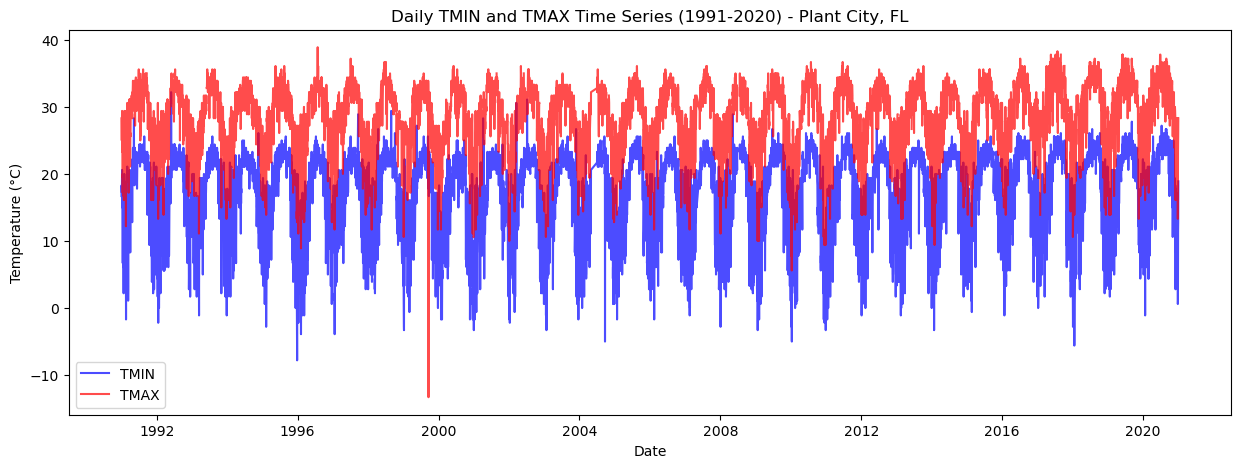

In [43]:
# plot TMIN and TMAX time series to verify interpolation worked as expected
plt.figure(figsize=(15,5))
plt.plot(data.index, data['TMIN'], label='TMIN', color='blue', alpha=0.7)
plt.plot(data.index, data['TMAX'], label='TMAX', color='red', alpha=0.7)
plt.title('Daily TMIN and TMAX Time Series (1991-2020) - Plant City, FL')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

In [52]:
# Calculate the mean fraction of days per month with TMIN below freezing (0°C)

# Method 1: the overall fraction of days in each month that are below freezing across the whole period 
# does NOT count by year first
fraction_freeze_whole_period = (data['TMIN'] < 0).groupby(data.index.month).mean()
fraction_freeze_whole_period

DATE
1     0.051668
2     0.015348
3     0.003226
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.001115
10    0.000000
11    0.001116
12    0.014039
Name: TMIN, dtype: float64

In [53]:
# Method 2: count by year first, then average the fractions across years

# mark freeze days as 1/0
data['is_freeze'] = (data['TMIN'] <= 0).astype(int)

# sum per (year, month), then average across years for each month
monthly_counts_per_year = data['is_freeze'].groupby([data.index.year, data.index.month]).sum()
mean_days_per_month = monthly_counts_per_year.groupby(level=1).mean()

avg_days_observed = data.groupby([data.index.year, data.index.month]).size().groupby(level=1).mean()
fraction_freeze_year_mean = mean_days_per_month / avg_days_observed  # uses average observed days per month
fraction_freeze_year_mean

DATE
1     0.060280
2     0.022432
3     0.003226
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.001115
10    0.000000
11    0.001116
12    0.019438
dtype: float64

### Observations: 
The calculation of the fraction of below-freezing days is _higher_ using Method 2. Since farmers are sensitive to risk, I'm going to use the more "pessimistic" method. 

In [54]:
# Calculate the same fraction of hard freeze days (TMIN <= -2.2°C)

# mark freeze days as 1/0
data['is_hard_freeze'] = (data['TMIN'] <= -2.2).astype(int)

# sum per (year, month), then average across years for each month
monthly_counts_per_year = data['is_hard_freeze'].groupby([data.index.year, data.index.month]).sum()
mean_days_per_month = monthly_counts_per_year.groupby(level=1).mean()

avg_days_observed = data.groupby([data.index.year, data.index.month]).size().groupby(level=1).mean()
fraction_hard_freeze_year_mean = mean_days_per_month / avg_days_observed  # uses average observed days per month
fraction_hard_freeze_year_mean

DATE
1     0.020452
2     0.002361
3     0.000000
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.001115
10    0.000000
11    0.000000
12    0.006479
dtype: float64

In [ ]:
# Combine results into a DataFrame for easier comparison
freeze_fractions = pd.DataFrame({
    'Fraction_Below_Freezing': fraction_freeze_year_mean,
    'Fraction_Below_Hard_Freezing': fraction_hard_freeze_year_mean
})
freeze_fractions

,Fraction_Below_Freezing,Fraction_Below_Hard_Freezing
DATE,,
1,0.060280,0.020452
2,0.022432,0.002361
3,0.003226,0.000000
4,0.000000,0.000000
5,0.000000,0.000000
6,0.000000,0.000000
7,0.000000,0.000000
8,0.000000,0.000000
9,0.001115,0.001115


In [58]:
# rename index to month names
freeze_fractions.index = range(1,13)

# rename the title of the index to "Month"
freeze_fractions.index.name = "Month"

freeze_fractions

,Fraction_Below_Freezing,Fraction_Below_Hard_Freezing
Month,,
1,0.060280,0.020452
2,0.022432,0.002361
3,0.003226,0.000000
4,0.000000,0.000000
5,0.000000,0.000000
6,0.000000,0.000000
7,0.000000,0.000000
8,0.000000,0.000000
9,0.001115,0.001115


### Part 1 Findings

In [59]:
# Risk Assessment: Risk is calculated in two ways
# 1) The fraction of days in a month with TMIN below freezing thresholds
# 2) The mean number of days per month with TMIN below freezing thresholds

freeze_fractions['Days_Below_Freezing'] = freeze_fractions['Fraction_Below_Freezing'] * avg_days_observed
freeze_fractions['Days_Below_Hard_Freezing'] = freeze_fractions['Fraction_Below_Hard_Freezing'] * avg_days_observed
freeze_fractions

,Fraction_Below_Freezing,Fraction_Below_Hard_Freezing,Days_Below_Freezing,Days_Below_Hard_Freezing
Month,,,,
1,0.060280,0.020452,1.866667,0.633333
2,0.022432,0.002361,0.633333,0.066667
3,0.003226,0.000000,0.100000,0.000000
4,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000
9,0.001115,0.001115,0.033333,0.033333


## Part 2

In [73]:
# Get the Nino indices from NOAA
# Credit to GPT-5 for this code snippet to parse the data  

# Convert CPC SSTI indices text file to a pandas DataFrame
import requests, re

url = "https://www.cpc.ncep.noaa.gov/data/indices/sstoi.indices"
txt = requests.get(url).text

# extract numeric tokens (integers and floats, including negatives)
tokens = re.findall(r'-?\d+\.\d+|-?\d+', txt)

# find the position of the first 4-digit year (>= 1980)
start = next(i for i,t in enumerate(tokens) if len(t) == 4 and int(t) >= 1980)

# group into records of 10 tokens: Year, Month, N1, N1_anom, N3, N3_anom, N4, N4_anom, N34, N34_anom
records = []
i = start
while i + 9 < len(tokens):
    rec = tokens[i:i+10]
    # basic sanity: month should be 1..12
    mon = int(rec[1])
    if 1 <= mon <= 12:
        records.append(rec)
        i += 10
    else:
        # if tokenization slipped (rare), skip one token and retry
        i += 1

cols = ['YR', 'MON',
        'NINO1+2', 'NINO1+2_ANOM',
        'NINO3',   'NINO3_ANOM',
        'NINO4',   'NINO4_ANOM',
        'NINO3.4', 'NINO3.4_ANOM']

df = pd.DataFrame(records, columns=cols)

# convert numeric columns to numbers (coerce any odd tokens to NaN)
for c in cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# tidy: create a date (first day of month) for convenience
df['DATE'] = pd.to_datetime(df['YR'].astype(int).astype(str) + '-' + df['MON'].astype(int).astype(str) + '-01')

# set index to date
enso = df.set_index('DATE').sort_index()

# keep only the period 1991-2020 to match temperature data
enso = enso[(enso.index.year >= 1991) & (enso.index.year <= 2020)]

enso

,YR,MON,NINO1+2,NINO1+2_ANOM,NINO3,NINO3_ANOM,NINO4,NINO4_ANOM,NINO3.4,NINO3.4_ANOM
DATE,,,,,,,,,,
1991-01-01,1991,1,23.73,-0.78,25.63,-0.05,28.62,0.40,26.89,0.33
1991-02-01,1991,2,25.70,-0.40,26.28,-0.10,28.40,0.30,26.87,0.14
1991-03-01,1991,3,26.32,-0.28,26.96,-0.20,28.38,0.15,27.16,-0.08
1991-04-01,1991,4,25.21,-0.52,27.39,-0.19,28.73,0.22,27.89,0.08
1991-05-01,1991,5,24.65,0.04,27.44,0.22,29.18,0.39,28.13,0.25
...,...,...,...,...,...,...,...,...,...,...
2020-08-01,2020,8,20.17,-0.69,24.79,-0.43,28.36,-0.34,26.38,-0.52
2020-09-01,2020,9,19.82,-0.76,24.21,-0.80,28.25,-0.43,26.12,-0.64
2020-10-01,2020,10,20.12,-0.76,24.19,-0.90,27.97,-0.71,25.64,-1.13


In [70]:
# Need to compare time-series of ENSO indices with hard freeze days
# Create a time series of hard freeze days per month to compare with ENSO indices

monthly_hf = data['is_hard_freeze'].groupby([data.index.year, data.index.month]).sum()

# convert MultiIndex (year, month) -> DatetimeIndex (first day of month) to match the ENSO index format
monthly_hf.index = pd.to_datetime([f"{int(y)}-{int(m):02d}-01" for y, m in monthly_hf.index])
monthly_hf = monthly_hf.sort_index()

# convert to DataFrame
monthly_hf = monthly_hf.to_frame(name='Hard_Freeze_Days')   
monthly_hf

,Hard_Freeze_Days
1991-01-01,0
1991-02-01,0
1991-03-01,0
1991-04-01,0
1991-05-01,0
...,...
2020-08-01,0
2020-09-01,0
2020-10-01,0
2020-11-01,0


In [ ]:
# Compare indexes to ensure they align
monthly_hf.index.equals(enso.index)  # should be True

# Where do the indexes not align?
monthly_hf.index.difference(enso.index), enso.index.difference(monthly_hf.index)    

# all of the differences are in months we don't care about, so now drop all non-winter months from the two dataframes
enso_winter = enso[enso.index.month.isin([10,11,12,1])]
monthly_hf_winter = monthly_hf[monthly_hf.index.month.isin([10,11,12,1])]

# Compare indexes again ensure they align
monthly_hf_winter.index.equals(enso_winter.index)  # should be True

# Excellent! Indices align! 

True